In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13300227541932965531
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14465892352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5347397092558300874
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import os
from tqdm.notebook import tqdm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import *
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.2 MB/s 


In [ ]:
#needed for DNN 
import tensorflow as tf
# import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM,GRU,Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
# from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
# from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
# from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.preprocessing.text import Tokenizer
# from sklearn.utils import shuffle

In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/drug review SA'

In [ ]:
df = pd.read_csv(PATH + '/data/results/clean_df.csv')
df = df.drop(['review','rating','vader_polarity', 'Review_Sentiment','blob_polarity', 'class_2' ], axis = 1)
df.head()

,cleaned_reviews,class
0,side effect take combination bystolic mg fish oil,neutral
1,son halfway fourth week intuniv become concern...,positve
2,use take another oral contraceptive pill cycle...,positve
3,first time use form birth control glad go patc...,positve
4,suboxone completely turn life around feel heal...,positve


In [ ]:
df.to_csv(PATH + '/data/results/manuscript_data.csv', index = False)

In [ ]:
# label encoding for output

sample_data = [2000,3000,100,2004,3080,4020]

def label_encoding(category,bool):
  le = preprocessing.LabelEncoder()
  le.fit(category)
  encoded_labels = le.transform(category)
  labels = np.array(encoded_labels) # Converting into numpy array
  class_names =le.classes_ ## Define the class names again
  if bool == True:
    print("\n\t\t\t Label Encoding ","\nClass Names:-->",le.classes_)
    for i in sample_data:
      print(category[i],' ', encoded_labels[i],'\n')
    return labels

labels = label_encoding(df['class'],True)


			 Label Encoding  
Class Names:--> ['negative' 'neutral' 'positve']
positve   2 

negative   0 

negative   0 

positve   2 

negative   0 

negative   0 



In [ ]:
# set aside 20% of train and test data for evaluation
df.cleaned_reviews=df.cleaned_reviews.astype(str)

X = df.cleaned_reviews
Y = labels

def dataset_split(inputs, tags):

    X,X_test,y,y_test = train_test_split(inputs,tags,train_size = 0.8,
                                                  test_size = 0.2,random_state =42)
    X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size = 0.95,
                                                  test_size = 0.05,random_state =42)
    print("\nDataset Distribution:\n")
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",len(inputs),
        "\n\tTraining\t\t",len(X_train),
        "\n\tTest\t\t\t",len(X_test),
        "\n\tValidation\t\t",len(X_valid))
  
    return X_train,X_valid,X_test,y_train,y_valid,y_test

X_train,X_valid,X_test,y_train,y_valid,y_test = dataset_split(X,Y)


Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 215063 
	Training		 163447 
	Test			 43013 
	Validation		 8603


In [ ]:
# Train Data Tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_length = 100
vocab_size = 43000  

tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>",filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',lower=True)
tokenizer.fit_on_texts(X_train.values)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Taining Data padding
train_sequences = tokenizer.texts_to_sequences(X_train.values)
train_padded = pad_sequences(train_sequences,padding='post', maxlen=max_length)

# Validation Data padding
validation_sequences = tokenizer.texts_to_sequences(X_valid.values)
validation_padded = pad_sequences(validation_sequences,padding='post', maxlen=max_length)

# testing data padding
test_sequences = tokenizer.texts_to_sequences(X_test.values)
test_padded = pad_sequences(test_sequences,padding='post',maxlen=max_length)

test_padded[0]

Found 41326 unique tokens.


array([ 1523, 34783,     1,   231,   741,     1,  3501,   295,   362,
         313,    14,   515,   160,   888,    27,  1437,   596,   399,
           8,  3856,   736,    36,     8,   844,    23,   977,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)

In [ ]:
import nltk
from tqdm import tqdm
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
####
embedding_vector = {}
f = open('/content/drive/MyDrive/Colab Notebooks/CyberBullying Detection/glove file/glove.6B.300d.txt',encoding="utf8")
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef
embedding_matrix = np.zeros((vocab_size,300))
for word,i in tqdm(word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

400000it [00:29, 13639.05it/s]
100%|██████████| 41326/41326 [00:00<00:00, 524054.99it/s]


In [ ]:
def padded_infos(original,encoded,padded):
  print("\n\t\t\t Encoded Sequences ","\n")  
  print(original,"\n",encoded) 
  print("\n\t\t\t Paded Sequences \n",original,"\n",padded)

padded_infos(X_train[1],train_sequences[1],train_padded[1])


			 Encoded Sequences  

son halfway fourth week intuniv become concerned begin last week start take high dose two day could hardly get bed cranky sleep nearly hour drive home school vacation unusual call doctor monday morning say stick day see school get morning last two day problem free much agreeable ever less emotional good thing less cranky remembering thing overall behavior well try many different medication far effective 
 [128, 7, 1914, 60, 8, 8, 388, 73, 217, 328, 5, 1938, 1379, 70, 87, 18, 2754]

			 Paded Sequences 
 son halfway fourth week intuniv become concerned begin last week start take high dose two day could hardly get bed cranky sleep nearly hour drive home school vacation unusual call doctor monday morning say stick day see school get morning last two day problem free much agreeable ever less emotional good thing less cranky remembering thing overall behavior well try many different medication far effective 
 [ 128    7 1914   60    8    8  388   73  217  328    5 

In [ ]:
#confusion matrix
def conf_matrix(y_pred):
  cm = confusion_matrix(y_test, y_pred) 

  cm_df = pd.DataFrame(cm,
                       index = ['negative', 'Neutral', 'Positive'], 
                       columns = ['negative', 'Neutral', 'Positive'])
  sns.set(font_scale=2) 
  plt.figure(figsize=(10,8))
  sns.heatmap(cm_df, annot=True,cmap="coolwarm", fmt='g')
  plt.ylabel('True label',fontsize=20)
  plt.xlabel('Predicted label',fontsize=20)
  plt.xticks( rotation=90, weight = 'bold')
  plt.yticks( rotation=0, weight = 'bold')
  plt.show()
  plt.close()

In [ ]:
accuracy_threshold = 0.999
from tensorflow import keras
keras.backend.clear_session()
#callback function for early stopping
class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()


In [ ]:
embedding_dim=300
num_category = 3
epochs = 100
batch = 128
opt=RMSprop(0.001)


In [ ]:
def Bidirectional_classifier_model(model_name,file_name,GRU_unit, epochs, batch, p_optimizer=opt , 
                                   p_loss:str = 'sparse_categorical_crossentropy', p_metrics:list = ['accuracy']):
    """
    Build a Bidirectional Models for classification
    """
    filepath = PATH + '/models/'+file_name
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.5, patience=2, 
                                    verbose=1, mode='auto', 
                                    min_delta=0.001, cooldown=1, min_lr=0.00001)
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='auto')
    
    callback_list = [acc_callback, checkpoint ]
    
    print('----------------------------- sequential_classifier_model -----------------------------')
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1],weights=[embedding_matrix], trainable=False),
        tf.keras.layers.SpatialDropout1D(0.2),
        tf.keras.layers.Bidirectional(model_name(GRU_unit,return_sequences=True)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_category, activation='sigmoid')
])
    model.compile(optimizer=p_optimizer, loss = p_loss, metrics = p_metrics)
    model.summary()
    model_history = model.fit(train_padded, y_train, 
                    epochs=epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, y_valid), 
                    verbose=1,
                    callbacks = callback_list)
    return model,model_history

In [ ]:
# Bidirection GRU 
BiGRU_model, BiGRU_history = Bidirectional_classifier_model(model_name = GRU,
                                                            file_name = 'glove_BiGRU.h5',
                                                            GRU_unit = 200,
                                                            epochs = epochs,
                                                            batch = batch)

----------------------------- sequential_classifier_model -----------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          12900000  
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 300)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 100, 400)         602400    
 l)                                                              
                                                                 
 dense (Dense)               (None, 100, 64)           25664     
                                                                 
 dropout (Dropout)           (None, 100, 64)           0         
                                  

In [ ]:
model_path = "/Ml files/drug review SA/models"

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [ ]:
#make predictions

model = load_model(model_path+"/glove_BiGRU.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)
evaluation = model.evaluate(test_padded,y_test)
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(precision_score(y_test, y_pred , average="macro")))
print('Recall {}'.format(recall_score(y_test, y_pred , average="macro")))
print('f1 score {}'.format(f1_score(y_test, y_pred , average="macro")))

conf_matrix(y_pred)

In [ ]:
#Report generation

def report_generate(pred,classifier):
  sns.set_style("whitegrid")
  report = pd.DataFrame(classification_report(y_true = y_test, y_pred =pred, output_dict=True)).transpose()
  report = report.rename(index={'0': 'negative','1':'Neutral','2':'Positive'})
  report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
  report=report.drop(["support"],axis=1)
  columns = ['precision','recall','f1-score']
  report.columns = columns
  plt = report.plot(kind='bar',figsize=(12,6))
  plt.set_title('Multi-class Classification Report for '+str(classifier)+' .', fontsize=20)
  plt.tick_params(axis='x',rotation=30,labelsize=25)
  plt.tick_params(axis='y',rotation=0,labelsize=25)
  plt.legend(['precision', 'recall', 'f1-score'], loc=2,bbox_to_anchor = (1,1), prop={'size': 20})
  plt.grid('white')
  return plt,report

In [ ]:
GRUreport=report_generate(y_pred,"BiGRU")
GRUreport[1]

In [ ]:
def model_evaluate(history):
  sns.set_style("whitegrid")
  H = history.history
  fig = plt.figure(figsize = (30, 8))
  plt.subplot(121)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation accuracy")
  plt.plot(H['accuracy'], label = 'training', marker='o', color='red', linewidth=3 )
  plt.plot(H['val_accuracy'], label = 'validation', marker='o', color='blue', linewidth=3 )
  plt.xticks( rotation=0, weight = 'bold', )
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend()

  plt.subplot(122)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation loss")
  plt.plot(H['loss'], label = 'training_loss', marker='o', color='red', linewidth=3 )
  plt.plot(H['val_loss'], label = 'validation_loss', marker='o', color='blue', linewidth=3 )
  plt.xticks( rotation=0, weight = 'bold', )
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend()
    
model_evaluate(BiGRU_history)

In [ ]:
BiLSTM_model, BiLSTM_history = Bidirectional_classifier_model(model_name = LSTM,
                                                            file_name = 'glove_BiLSTM.h5',
                                                            GRU_unit = 200,
                                                            epochs = epochs,
                                                            batch = batch)

In [ ]:
#make predictions
model = load_model(model_path+"/glove_BiLSTM.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)
evaluation = model.evaluate(test_padded,y_test)
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(precision_score(y_test, y_pred , average="macro")))
print('Recall {}'.format(recall_score(y_test, y_pred , average="macro")))
print('f1 score {}'.format(f1_score(y_test, y_pred , average="macro")))

conf_matrix(y_pred)

In [ ]:
BiLSTMreport=report_generate(y_pred,"BiLSTM")
BiLSTMreport[1]

In [ ]:
model_evaluate(BiLSTM_history)

In [ ]:
def directional_classifier_model(model_name,file_name,GRU_unit, epochs, batch, p_optimizer= opt , 
                                   p_loss:str = 'sparse_categorical_crossentropy', p_metrics:list = ['accuracy']):
    """
    Build a directional Models for classification
    """
    filepath = PATH+ '/models/'+file_name
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.5, patience=2, 
                                    verbose=1, mode='auto', 
                                    min_delta=0.001, cooldown=1, min_lr=0.00001)
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='auto')
    
    callback_list = [acc_callback, checkpoint]
    
    print('----------------------------- sequential_classifier_model -----------------------------')
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1],weights=[embedding_matrix], trainable=False),
        tf.keras.layers.SpatialDropout1D(0.2),
        model_name(GRU_unit,return_sequences=True),
#         model_name(128, dropout = 0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_category, activation='sigmoid')
])
    model.compile(optimizer=p_optimizer, loss = p_loss, metrics = p_metrics)
    model.summary()
    model_history = model.fit(train_padded, y_train, 
                    epochs=epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, y_valid), 
                    verbose=1,
                    callbacks = callback_list)
    return model,model_history

In [ ]:
LSTM_model, LSTM_history =directional_classifier_model(model_name = LSTM,
                                                            file_name = 'glove_LSTM.h5',
                                                            GRU_unit = 200,
                                                            epochs = epochs,
                                                            batch = batch)


In [ ]:
model_evaluate(LSTM_history)

In [ ]:
#make predictions
model = load_model(model_path+"/glove_LSTM.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)
evaluation = model.evaluate(test_padded,y_test)
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(precision_score(y_test, y_pred , average="macro")))
print('Recall {}'.format(recall_score(y_test, y_pred , average="macro")))
print('f1 score {}'.format(f1_score(y_test, y_pred , average="macro")))

conf_matrix(y_pred)

In [ ]:
LSTMreport=report_generate(y_pred,"LSTM")
LSTMreport[1]

In [ ]:
GRU_model, GRU_history =directional_classifier_model(model_name = GRU,
                                                            file_name = 'glove_GRU.h5',
                                                            GRU_unit = 200,
                                                            epochs = epochs,
                                                            batch = batch)


In [ ]:
model_evaluate(GRU_history)

In [ ]:
#make predictions
model = load_model(model_path+"/glove_GRU.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)
evaluation = model.evaluate(test_padded,y_test)
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(precision_score(y_test, y_pred , average="macro")))
print('Recall {}'.format(recall_score(y_test, y_pred , average="macro")))
print('f1 score {}'.format(f1_score(y_test, y_pred , average="macro")))

conf_matrix(y_pred)

In [ ]:
GRUreport=report_generate(y_pred,"GRU")
GRUreport[1]

In [ ]:
# Plot all model results
def model_all_evaluate(history1,history2,history3,history4):
  sns.set_style("whitegrid")
  H1 = history1.history
  H2 = history2.history
  H3 = history3.history
  H4 = history4.history
  fig = plt.figure(figsize = (20, 8))
  plt.subplot(121)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation accuracy")
  plt.plot(H1['val_accuracy'], label = 'BiGRU', marker='o', color='red', linewidth=3)
  plt.plot(H2['val_accuracy'], label = 'BiLSTM', marker='o', color='blue', linewidth=3)
  plt.plot(H3['val_accuracy'], label = 'LSTM', marker='o', color='yellow', linewidth=3)
  plt.plot(H4['val_accuracy'], label = 'GRU', marker='o', color='green', linewidth=3)
  plt.xticks( rotation=0, weight = 'bold')
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend(prop={'size': 20})

  plt.subplot(122)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation loss")
  plt.plot(H1['val_loss'], label = 'BiGRU', marker='o', color='red', linewidth=3)
  plt.plot(H2['val_loss'], label = 'BiLSTM', marker='o', color='blue', linewidth=3)
  plt.plot(H3['val_loss'], label = 'LSTM', marker='o', color='yellow', linewidth=3)
  plt.plot(H4['val_loss'], label = 'GRU', marker='o', color='green', linewidth=3)
  plt.xticks( rotation=0, weight = 'bold')
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend(prop={'size': 20})

    
model_all_evaluate(BiGRU_history, BiLSTM_history,LSTM_history, GRU_history )

In [ ]:
Bigru = load_model(model_path+"/glove_BiGRU.h5")
Bilstm = load_model(model_path+"/glove_BiLSTM.h5")
lstm = load_model(model_path+"/glove_LSTM.h5")
gru = load_model(model_path+"/glove_GRU.h5")
MLA = {
     'Bidirectional GRU' : Bigru,
     'Bidirectional LSTM' : Bilstm,
     'LSTM' : lstm,
     'GRU' : gru, 
}

columns = []
compare = pd.DataFrame(columns = columns)
# n_classes=4
row_index = 0
for name,alg in MLA.items():
    MLA_name = name
    evaluation = alg.evaluate(test_padded,y_test)
    y_pred = alg.predict(test_padded)
    y_pred = np.argmax(predictions, axis=1)
    weighted_averaged_recall = recall_score(y_test, y_pred, average='micro')
    weighted_averaged_precision = precision_score(y_test, y_pred,  average='macro')

    weighted_averaged_f1 = 2*((weighted_averaged_recall*weighted_averaged_precision)/(weighted_averaged_recall+weighted_averaged_precision))
    compare.loc[row_index,'Name'] = MLA_name
    compare.loc[row_index, 'Accuracy'] = evaluation[1]
    compare.loc[row_index, 'loss'] = evaluation[0]
    compare.loc[row_index, 'Precision'] = weighted_averaged_precision
    compare.loc[row_index, 'Recall'] = weighted_averaged_recall
    compare.loc[row_index, 'F1 Score'] = weighted_averaged_f1
   

    row_index+=1
    
compare.sort_values(by = ['Accuracy'], ascending = False, inplace = True)    
compare

**DIrectional Hybrid Model**

**CNN-LSTM**

In [ ]:
def directional_hybrid_classifier_model(model_name,file_name,GRU_unit, epochs, batch, p_optimizer = opt , 
                                   p_loss:str = 'sparse_categorical_crossentropy', p_metrics:list = ['accuracy']):
    """
    Build a directional Models for classification
    """
    filepath = PATH + '/models/'+file_name
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.5, patience=2, 
                                    verbose=1, mode='auto', 
                                    min_delta=0.001, cooldown=1, min_lr=0.00001)
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='auto')
    
    callback_list = [acc_callback, checkpoint]
    
    print('----------------------------- Hybrid_sequential_classifier_model -----------------------------')
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1],weights=[embedding_matrix], trainable=False),
        tf.keras.layers.SpatialDropout1D(0.7),
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        model_name(GRU_unit,return_sequences=True),
        # tf.keras.layers.Dense(128, activation='relu'),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_category, activation='sigmoid')
])
    model.compile(optimizer=p_optimizer, loss = p_loss, metrics = p_metrics)
    model.summary()
    model_history = model.fit(train_padded, y_train, 
                    epochs=epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, y_valid), 
                    verbose=1,
                    callbacks = callback_list)
    return model,model_history

In [ ]:
CLSTM_model, CLSTM_history =directional_hybrid_classifier_model(model_name = LSTM,
                                                            file_name = 'glove_CLSTM.h5',
                                                            GRU_unit =200,
                                                            epochs = epochs,
                                                            batch = batch)
model_evaluate(CLSTM_history)

In [ ]:
print(CLSTM_history.history['val_accuracy'])
print(CLSTM_history.history['val_loss'])

In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/drug review SA/models'

In [ ]:
#make predictions
model = load_model(model_path+"/glove_CLSTM.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)
evaluation = model.evaluate(test_padded,y_test)
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(precision_score(y_test, y_pred , average="macro")))
print('Recall {}'.format(recall_score(y_test, y_pred , average="macro")))
print('f1 score {}'.format(f1_score(y_test, y_pred , average="macro")))

conf_matrix(y_pred)

**CNN-GRU**

In [ ]:
CGRU_model, CGRU_history =directional_hybrid_classifier_model(model_name = GRU,
                                                            file_name = 'glove_CGRU.h5',
                                                            GRU_unit =200,
                                                            epochs = epochs,
                                                            batch = batch)


In [ ]:
print(CGRU_history.history['val_accuracy'])
print(CGRU_history.history['val_loss'])

In [ ]:
model_evaluate(CGRU_history)

In [ ]:
#make predictions

model = load_model(model_path+"/glove_CGRU.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)
evaluation = model.evaluate(test_padded,y_test)
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(precision_score(y_test, y_pred , average="macro")))
print('Recall {}'.format(recall_score(y_test, y_pred , average="macro")))
print('f1 score {}'.format(f1_score(y_test, y_pred , average="macro")))

conf_matrix(y_pred)

**Bi-directional Hybrid Model**

In [ ]:
def bidirectional_hybrid_classifier_model(model_name,file_name,GRU_unit, epochs, batch, p_optimizer = opt , 
                                   p_loss:str = 'sparse_categorical_crossentropy', p_metrics:list = ['accuracy']):
    """
    Build a directional Models for classification
    """
    filepath =PATH + '/models/'+file_name
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.5, patience=2, 
                                    verbose=1, mode='auto', 
                                    min_delta=0.001, cooldown=1, min_lr=0.00001)
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='auto')
    
    callback_list = [acc_callback, checkpoint]
    
    print('----------------------------- Biderectional Hybrid_sequential_classifier_model -----------------------------')
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1],weights=[embedding_matrix], trainable=False),
        tf.keras.layers.SpatialDropout1D(0.7),
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
        
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Bidirectional(model_name(GRU_unit,return_sequences=True)),
        # tf.keras.layers.Dense(128, activation='relu'),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_category, activation='sigmoid')
])
    model.compile(optimizer=p_optimizer, loss = p_loss, metrics = p_metrics)
    model.summary()
    model_history = model.fit(train_padded, y_train, 
                    epochs=epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, y_valid), 
                    verbose=1,
                    callbacks = callback_list)
    return model,model_history

**CNN-BiLSTM**

In [ ]:
CBILSTM_model, CBILSTM_history =bidirectional_hybrid_classifier_model(model_name = LSTM,
                                                            file_name = 'glove_CBILSTM.h5',
                                                            GRU_unit =200,
                                                            epochs = epochs,
                                                            batch = batch)
model_evaluate(CBILSTM_history)

In [ ]:
print(CBILSTM_history.history['val_accuracy'])
print(CBILSTM_history.history['val_loss'])

In [ ]:
#make predictions


model = load_model(model_path+"/glove_CBILSTM.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)
evaluation = model.evaluate(test_padded,y_test)
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(precision_score(y_test, y_pred , average="macro")))
print('Recall {}'.format(recall_score(y_test, y_pred , average="macro")))
print('f1 score {}'.format(f1_score(y_test, y_pred , average="macro")))

conf_matrix(y_pred)

**CNN-BiGRU**

In [ ]:
CBIGRU_model, CBIGRU_history =bidirectional_hybrid_classifier_model(model_name = GRU,
                                                            file_name = 'glove_CBIGRU.h5',
                                                            GRU_unit =200,
                                                            epochs = epochs,
                                                            batch = batch)


In [ ]:
model_evaluate(CBIGRU_history)

In [ ]:
print(CBIGRU_history.history['val_accuracy'])
print(CBIGRU_history.history['val_loss'])

In [ ]:
#make predictions
model = load_model(model_path+"/glove_CBIGRU.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)
evaluation = model.evaluate(test_padded,y_test)
print('loss {}'.format(evaluation[0]))
print('Accuracy {}'.format(evaluation[1]))
print('Precision {}'.format(precision_score(y_test, y_pred , average="macro")))
print('Recall {}'.format(recall_score(y_test, y_pred , average="macro")))
print('f1 score {}'.format(f1_score(y_test, y_pred , average="macro")))

conf_matrix(y_pred)

In [ ]:
# Plot all model results
def model_all_evaluate(history1,history2,history3,history4):
  sns.set_style("whitegrid")
  H1 = history1.history
  H2 = history2.history
  H3 = history3.history
  H4 = history4.history
  fig = plt.figure(figsize = (20, 8))
  plt.subplot(121)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation accuracy")
  plt.plot(H1['val_accuracy'], label = 'CNN-BiGRU', marker='o', color='red', linewidth=3)
  plt.plot(H2['val_accuracy'], label = 'CNN-BiLSTM', marker='o', color='blue', linewidth=3)
  plt.plot(H3['val_accuracy'], label = 'CNN-LSTM', marker='o', color='yellow', linewidth=3)
  plt.plot(H4['val_accuracy'], label = 'CNN-GRU', marker='o', color='green', linewidth=3)
  plt.xticks( rotation=0, weight = 'bold')
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend(prop={'size': 20})

  plt.subplot(122)
  plt.xlabel("number of epoch")
  plt.ylabel("Validation loss")
  plt.plot(H1['val_loss'], label = 'CNN-BiGRU', marker='o', color='red', linewidth=3)
  plt.plot(H2['val_loss'], label = 'CNN-BiLSTM', marker='o', color='blue', linewidth=3)
  plt.plot(H3['val_loss'], label = 'CNN-LSTM', marker='o', color='yellow', linewidth=3)
  plt.plot(H4['val_loss'], label = 'CNN-GRU', marker='o', color='green', linewidth=3)
  plt.xticks( rotation=0, weight = 'bold')
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend(prop={'size': 20})


In [ ]:
model_all_evaluate(CBIGRU_history, CBILSTM_history,CLSTM_history, CGRU_history )

In [ ]:
CBigru = load_model(model_path+"models/glove_CBIGRU.h5")
CBilstm = load_model(model_path+"models/glove_CBILSTM.h5")
Clstm = load_model(model_path+"models/glove_CLSTM.h5")
Cgru = load_model(model_path+"models/glove_CGRU.h5")
MLA = {
     'CNN-BiRU' : CBigru,
     'CNN-BiLSTM' : CBilstm,
     'CNN-LSTM' : Clstm,
     'CNN-GRU' : Cgru, 
}
columns = []
hybrid_compare = pd.DataFrame(columns = columns)
# n_classes=4
row_index = 0
for name,alg in MLA.items():
    MLA_name = name
    evaluation = alg.evaluate(test_padded,y_test)
    y_pred = alg.predict(test_padded)
    y_pred = np.argmax(predictions, axis=1)
    weighted_averaged_recall = average_precision_score(y_test, y_pred, average='micro')
    weighted_averaged_precision = average_precision_score(y_test, y_pred,  average='macro')

    weighted_averaged_f1 = 2*((weighted_averaged_recall*weighted_averaged_precision)/(weighted_averaged_recall+weighted_averaged_precision))
    hybrid_compare.loc[row_index,'Name'] = MLA_name
    hybrid_compare.loc[row_index, 'Accuracy'] = evaluation[1]
    hybrid_compare.loc[row_index, 'loss'] = evaluation[0]
    hybrid_compare.loc[row_index, 'Precision'] = weighted_averaged_precision
    hybrid_compare.loc[row_index, 'Recall'] = weighted_averaged_recall
    hybrid_compare.loc[row_index, 'F1 Score'] = weighted_averaged_f1
   

    row_index+=1
    
hybrid_compare.sort_values(by = ['Accuracy'], ascending = False, inplace = True)    
hybrid_compare

In [2]:
cm = pd.read_csv('/content/tfidf.csv',  
                       index_col=0)
cm = cm[:4]
cm.head()

,Political,Acceptable,Religious,Sexual
Political,1006,73,9,40
Acceptable,85,872,16,98
Religious,25,47,802,50
Sexual,40,89,23,939


In [12]:
#confusion matrix
def conf_matrix(cm):
  cm_df = cm
  sns.set(font_scale=2) 
  plt.figure(figsize=(8,6))
  sns.heatmap(cm_df, annot=True,cmap="YlGnBu", fmt='g')
  plt.ylabel('True label',fontsize=20)
  plt.xlabel('Predicted label',fontsize=20)
  plt.xticks( rotation=45, weight = 'bold')
  plt.yticks( rotation=45, weight = 'bold')
  plt.show()
  plt.close()

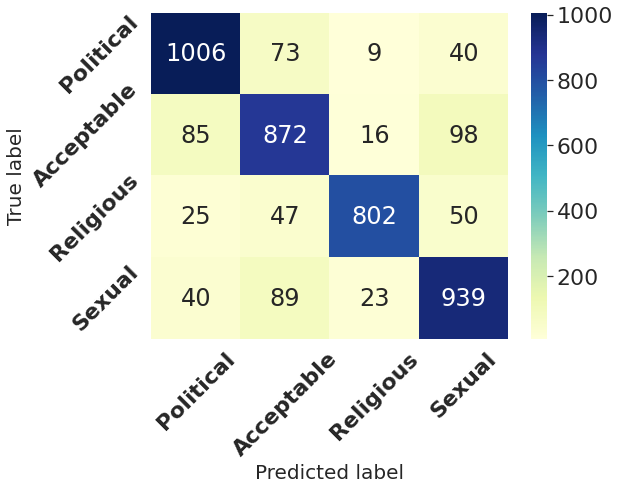

In [13]:
conf_matrix(cm)